In [1]:
# Import the huggingface dataset
from datasets import load_dataset

import pandas as pd
import numpy as np

# DL
import torch
from torch.utils.data import Dataset

# Statistics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from scipy import stats

# For text processing
import re
import string

# For sentiment analysis
from textblob import TextBlob

# For BERT
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:
# BERT on the train_dl created
train_dl = pd.read_csv('balanced_data_files/train_dl.csv')
val_dl = pd.read_csv('balanced_data_files/val_dl.csv')

print(train_dl.head())
print(train_dl.shape)
print(train_dl.info())
print(train_dl.columns)

                                          Email Text  label
0  re : rolex order details - m 3945 s rolex : $ ...      1
1  aisb96 call for workshop proposals - - - - - -...      0
2  query : not not dear linguists , i am working ...      0
3  Update of /cvsroot/spamassassin/spamassassin/m...      0
4  URL: http://boingboing.net/#85482211\nDate: No...      0
(13054, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13054 entries, 0 to 13053
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email Text  13041 non-null  object
 1   label       13054 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 204.1+ KB
None
Index(['Email Text', 'label'], dtype='object')


In [4]:
# Cell 4: Exploratory Data Analysis (EDA)

# Rename 'Email Text' to 'text' for convenience (optional)
train_dl = train_dl.rename(columns={'Email Text': 'text'})

# Look at text lengths
train_dl['text_length'] = train_dl['text'].apply(lambda x: len(str(x).split()))
print(train_dl['text_length'].describe())


count    1.305400e+04
mean     6.125063e+02
std      3.088025e+04
min      0.000000e+00
25%      7.400000e+01
50%      1.600000e+02
75%      3.550000e+02
max      3.527576e+06
Name: text_length, dtype: float64


In [5]:
# Check for missing values
print("Number of NaN values in text column:", train_dl['text'].isna().sum())

Number of NaN values in text column: 13


In [6]:
def clean_text(text):
    # Check if text is NaN or None
    if isinstance(text, float) and pd.isna(text):
        return ""  # Return empty string for NaN values

    # Convert to string to handle any numeric values
    text = str(text)

    # Example: remove HTML tags, if any
    text = re.sub(r'<.*?>', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

train_dl['clean_text'] = train_dl['text'].apply(clean_text)

# Show a sample
print(train_dl['clean_text'].iloc[0])

re : rolex order details - m 3945 s rolex : $ 129 cartier : $ 119 and more ? no thanks -


In [7]:
# Cell 6:  Linguistic Features (Sentiment Analysis)

def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # ranges from -1 (negative) to +1 (positive)

train_dl['sentiment'] = train_dl['clean_text'].apply(get_sentiment)         # Original
print(train_dl[['clean_text', 'sentiment']].head(10))


                                          clean_text  sentiment
0  re : rolex order details - m 3945 s rolex : $ ...   0.200000
1  aisb96 call for workshop proposals - - - - - -...   0.027022
2  query : not not dear linguists , i am working ...   0.036392
3  Update of /cvsroot/spamassassin/spamassassin/m...   0.067273
4  URL: http://boingboing.net/#85482211 Date: Not...  -0.030556
5  wc 551 revision and notice of force majeure ( ...   0.016667
6  clean ur computer now 3 ey there is a 85 % cha...  -0.108333
7  3 locations free : orlando , las vegas , ft la...   0.294582
8  re : the virtual girlfriend and virtual boyfri...   0.170754
9  re : probation period - matthew williams hi ka...   0.190833


D:\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\.venv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\.venv\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


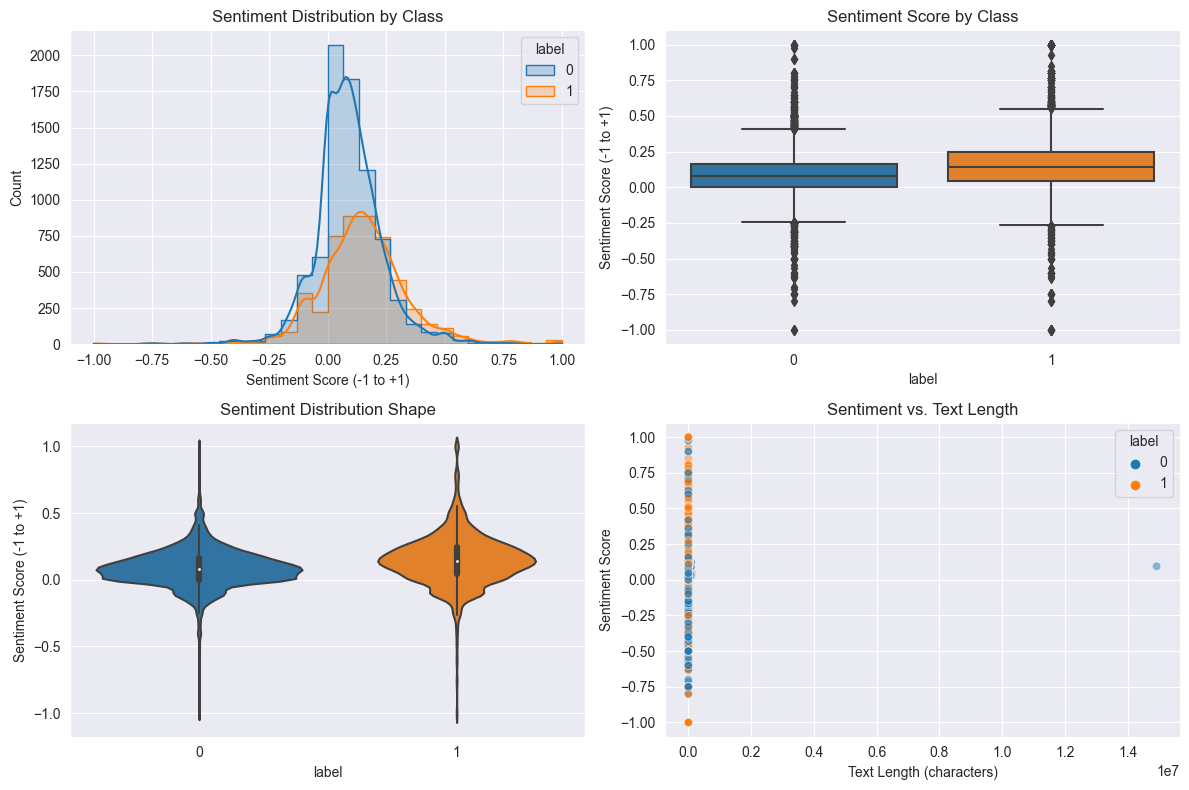

Non-phishing (Safe) Sentiment Statistics:
count    7924.000000
mean        0.088843
std         0.146831
min        -1.000000
25%         0.000000
50%         0.082006
75%         0.163889
max         1.000000
Name: sentiment, dtype: float64

Phishing Sentiment Statistics:
count    5130.000000
mean        0.150151
std         0.192059
min        -1.000000
25%         0.041557
50%         0.144723
75%         0.247535
max         1.000000
Name: sentiment, dtype: float64

T-test results: t-statistic = -19.4738, p-value = 0.000000
Statistically significant difference: True
safe Sentiment Statistics:
count    7924.000000
mean        0.088843
std         0.146831
min        -1.000000
25%         0.000000
50%         0.082006
75%         0.163889
max         1.000000
Name: sentiment, dtype: float64

phish Sentiment Statistics:
count    5130.000000
mean        0.150151
std         0.192059
min        -1.000000
25%         0.041557
50%         0.144723
75%         0.247535
max         1.000000

In [8]:
# Visualizing sentiment distribution
plt.figure(figsize=(12, 8))

# Plot 1: Sentiment distribution by class
plt.subplot(2, 2, 1)
sns.histplot(data=train_dl, x='sentiment', hue='label', element='step', bins=30, kde=True)
plt.title('Sentiment Distribution by Class')
plt.xlabel('Sentiment Score (-1 to +1)')

# Plot 2: Box plot of sentiment by class
plt.subplot(2, 2, 2)
sns.boxplot(x='label', y='sentiment', data=train_dl)
plt.title('Sentiment Score by Class')
plt.ylabel('Sentiment Score (-1 to +1)')

# Plot 3: Violin plot to see distribution shape
plt.subplot(2, 2, 3)
sns.violinplot(x='label', y='sentiment', data=train_dl)
plt.title('Sentiment Distribution Shape')
plt.ylabel('Sentiment Score (-1 to +1)')

# Plot 4: Scatter plot of text length vs sentiment
train_dl['text_length'] = train_dl['clean_text'].apply(len)
plt.subplot(2, 2, 4)
sns.scatterplot(x='text_length', y='sentiment', hue='label', data=train_dl, alpha=0.5)
plt.title('Sentiment vs. Text Length')
plt.xlabel('Text Length (characters)')
plt.ylabel('Sentiment Score')

plt.tight_layout()
plt.show()

# Statistical analysis - use numeric values 0 and 1 instead of 'safe' and 'phish'
safe_sentiment = train_dl[train_dl['label'] == 0]['sentiment']  # 0 for non-phishing
phish_sentiment = train_dl[train_dl['label'] == 1]['sentiment'] # 1 for phishing

print("Non-phishing (Safe) Sentiment Statistics:")
print(safe_sentiment.describe())
print("\nPhishing Sentiment Statistics:")
print(phish_sentiment.describe())

# Run t-test to compare sentiment means
t_stat, p_value = stats.ttest_ind(safe_sentiment, phish_sentiment, equal_var=False)
print(f"\nT-test results: t-statistic = {t_stat:.4f}, p-value = {p_value:.6f}")
print(f"Statistically significant difference: {p_value < 0.05}")
print("safe Sentiment Statistics:")
print(safe_sentiment.describe())
print("\nphish Sentiment Statistics:")
print(phish_sentiment.describe())

# Run t-test to compare sentiment means
t_stat, p_value = stats.ttest_ind(safe_sentiment, phish_sentiment, equal_var=False)
print(f"\nT-test results: t-statistic = {t_stat:.4f}, p-value = {p_value:.6f}")
print(f"Statistically significant difference: {p_value < 0.05}")

In [13]:
# Add this before creating datasets
print("Train columns:", train_dl.columns.tolist())
print("Val columns:", val_dl.columns.tolist())

Train columns: ['text', 'label', 'text_length', 'clean_text', 'sentiment']
Val columns: ['Email Text', 'label']


In [10]:
class EmailDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Try using 'text' instead of 'clean_text'
        # If 'text' doesn't exist, try 'Email Text'
        if 'text' in self.df.columns:
            text = self.df.loc[idx, 'text']
        elif 'Email Text' in self.df.columns:
            text = self.df.loc[idx, 'Email Text']
        else:
            # Print column names to help debug
            print(f"Available columns: {self.df.columns.tolist()}")
            raise KeyError("Could not find text column. Please specify the correct column name.")

        # Use the numeric label directly
        label = self.df.loc[idx, 'label']

        # Ensure text is a string
        text = str(text) if text is not None else ""

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [14]:
# Cell 8: Unified Dataset Preparation

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class EmailDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Determine text column based on available columns
        if 'clean_text' in self.df.columns:
            self.text_column = 'clean_text'
        elif 'text' in self.df.columns:
            self.text_column = 'text'
        elif 'Email Text' in self.df.columns:
            self.text_column = 'Email Text'
        else:
            raise KeyError(f"No suitable text column found in {self.df.columns.tolist()}")

        print(f"Using '{self.text_column}' column for text in dataset with {len(self.df)} samples")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get text using the appropriate column
        text = self.df.loc[idx, self.text_column]

        # Get label
        label = self.df.loc[idx, 'label']

        # Ensure text is a string
        text = str(text) if text is not None else ""

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets with the unified EmailDataset class
train_dataset = EmailDataset(train_dl, tokenizer)
val_dataset = EmailDataset(val_dl, tokenizer)

print("Tokenization complete!")

D:\.venv\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Using 'clean_text' column for text in dataset with 13054 samples
Using 'Email Text' column for text in dataset with 2798 samples
Tokenization complete!


In [18]:
# Cell 9: BERT Model & Trainer
# Initialize BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='D:\\phishing_repo_thesis\\Results\\bert_output',  # Note the double backslashes for Windows paths
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy='epoch',
    logging_dir='D:\\phishing_repo_thesis\\Results\\bert_logs',  # Also update logs path
    logging_steps=50,
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='none'
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

D:\.venv\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassifi

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.079900,0.101526,0.966762,0.959193,0.926271,0.994540
2,0.040000,0.103740,0.977127,0.971505,0.951177,0.992721
3,0.032800,0.106052,0.977484,0.971583,0.963327,0.979982
4,0.019100,0.094409,0.979271,0.973850,0.965147,0.982712
5,0.027000,0.089781,0.979628,0.974382,0.962700,0.986351


TrainOutput(global_step=8160, training_loss=0.06519721556071412, metrics={'train_runtime': 1791.8042, 'train_samples_per_second': 36.427, 'train_steps_per_second': 4.554, 'total_flos': 4293314645836800.0, 'train_loss': 0.06519721556071412, 'epoch': 5.0})

Evaluation Results: {'eval_loss': 0.06385201215744019, 'eval_accuracy': 0.9796283059328091, 'eval_f1': 0.9743127534925642, 'eval_precision': 0.9651785714285714, 'eval_recall': 0.9836214740673339}
Validation Accuracy: 0.9796

Classification Report:
                precision    recall  f1-score   support

    Safe Email       0.99      0.98      0.98      1699
Phishing Email       0.97      0.98      0.97      1099

      accuracy                           0.98      2798
     macro avg       0.98      0.98      0.98      2798
  weighted avg       0.98      0.98      0.98      2798


Confusion Matrix:
[[1660   39]
 [  18 1081]]


FileNotFoundError: [Errno 2] No such file or directory: 'Results/bert_confusion_matrix.png'

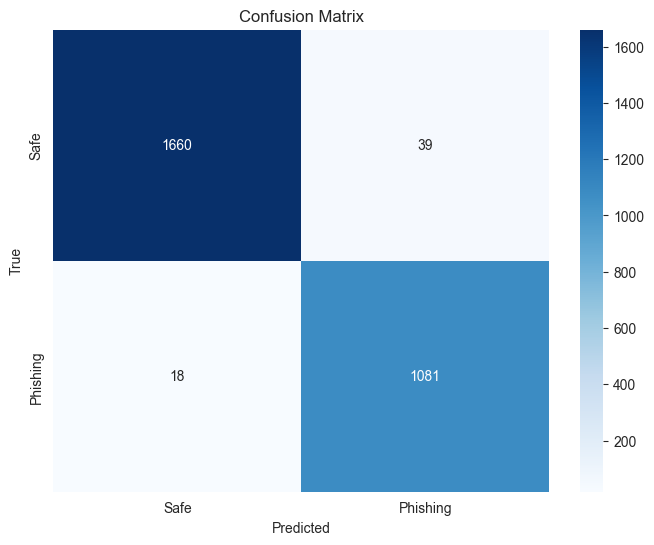

In [17]:
# Cell 10: Evaluation & Prediction
# Make predictions on validation data
eval_results = trainer.evaluate(val_dataset)
print("Evaluation Results:", eval_results)

# Predict on validation samples
predictions = trainer.predict(val_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Get true labels from prediction object instead of dataset
true_labels = predictions.label_ids

# Calculate accuracy
accuracy = np.mean(pred_labels == true_labels)
print(f"Validation Accuracy: {accuracy:.4f}")

# Get more detailed metrics
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels,
                           target_names=['Safe Email', 'Phishing Email']))

# Display confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(true_labels, pred_labels)
print(cm)

# Optional: Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Safe', 'Phishing'],
           yticklabels=['Safe', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('Results/bert_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()